## Quantum Machine Learning Demo
Data obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) and sklearn 
 
This is the quantum comparison to the classical machine learning of the same data
 
 

# Load Packages

In [1]:
from sklearn import datasets
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector,Parameter  # to set paramaters and multiple at once
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

from utils2 import *

# Load Data

In [2]:
data = datasets.load_breast_cancer()
x= data.data
y=data.target

# 212 M for malignant and 357 B for begnin, 0 --> 'M' and 1--> 'B'

df = pd.DataFrame(x)

# dataframe comes with unamed components, this labells them suchly

feature_names = data.feature_names
df.columns = feature_names

#Let's see how many components we have

print(len(df.columns))

df

30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


As we see, our data set works with 30 components/observed variables, from our 569 cancer samples, that each could give unique insight into the outcome of cancer, or be completely extraneous. Some variables could even give key information, in relation to each other. 

Even though 30 isn't considered a lot in the context of machine learning, quantum machine learning often matches one variable to one qubit. There are only so many qubits in the quantum sphere, and for the sake of this demo, we will cut this down to 8 qubits and later run this on a quantum simulator for 8 qubits. For the kernel we choose later, we need to use a power of 2 for the number of qubits

To do this, we will peform [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), not before we normalize the data, to adjust for varying ranges in each component. Let's choose a [minmax scaler](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python).

In [3]:
scaler = MinMaxScaler()
scaler.fit(df)
scaler.data_max_
x_scaled = scaler.transform(df)

print(x_scaled, x) # for comparison

[[0.52103744 0.0226581  0.54598853 ... 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 ... 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 ... 0.83505155 0.40370589 0.21343303]
 ...
 [0.45525108 0.62123774 0.44578813 ... 0.48728522 0.12872068 0.1519087 ]
 [0.64456434 0.66351031 0.66553797 ... 0.91065292 0.49714173 0.45231536]
 [0.03686876 0.50152181 0.02853984 ... 0.         0.25744136 0.10068215]] [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


Now let's create a new data frame with our scaled data, encompassing PCA data

In [4]:
pca8 = PCA(8)

p_components = pca8.fit_transform(x_scaled)

names = []
for i in range(1, 9): # 0 based indexing, gives us pc1-pc8
    names.append("pc" + str(i))


pdf = pd.DataFrame(data= p_components, columns= names)

pdf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,1.387021,0.426895,-0.541703,0.048483,-0.072198,0.190817,0.236314,-0.039457
1,0.462308,-0.556947,-0.205175,-0.042830,0.016111,0.015603,0.043139,0.020644
2,0.954621,-0.109701,-0.147848,-0.001068,-0.033798,0.069062,-0.108167,0.007366
3,1.000816,1.525089,-0.053271,-0.207916,-0.219381,0.388007,0.194518,0.143506
4,0.626828,-0.302471,-0.409336,0.238811,-0.002192,-0.157212,-0.063307,0.045929
...,...,...,...,...,...,...,...,...
564,1.002840,-0.474785,-0.100041,0.272995,-0.083888,-0.309121,-0.129457,0.006009
565,0.620757,-0.517200,0.400360,0.182443,-0.092984,-0.046000,-0.083334,-0.111680
566,0.226311,-0.287946,0.315224,-0.011747,0.218517,-0.080005,-0.030992,0.015707
567,1.677834,0.335946,0.296116,-0.156305,0.070204,0.109057,0.068627,-0.092473


# Split Training and Test Data

In [5]:
pdf_array = np.array(pdf) #for the train_test_split()

#As is often standard,  the test suze will encompass 20% of our given data
x_train, x_test, y_train, y_test = train_test_split(pdf_array, y, test_size=20, random_state=5)

## Data Embedding

One of the most important facets of quantum machne learning is the kernel upon which you embed your data. In personal experience, I find a custom raw angle embedding feature map and corresponding kernel to be best. Let's define a function for our angle embedding feature map.

In [6]:
def angle_embedding(num_features):
       
    """
    Returns a quantum circuit consisting of x rotations to function as a feature map, encompassing of any num_features (int)
    Where the x rotations will later correspond to the data

    : qc: The quantum circuit.
    : num_features: The number of features of the feature vector. (AKA the number of pricnipal components)
  
    """
    assert num_features 
    
    x_params = ParameterVector("x", num_features) #"x" is a generic label, useful for denotating as x rotations
    qc = QuantumCircuit(num_features)

    for i in range(num_features):
        qc.rx(x_params[i], i)
        
    return qc

[ 6.09561498e-01  3.05679018e-01 -1.12360208e-01  1.08207311e-01
  1.66774404e-01  8.89749261e-02 -1.61175555e-01 -5.07711447e-04]
[-5.34651622e-01 -9.02499018e-02 -7.90499609e-02 -2.15800892e-02
 -5.00496408e-03  9.70430786e-02 -2.39866183e-04  1.31405150e-02]


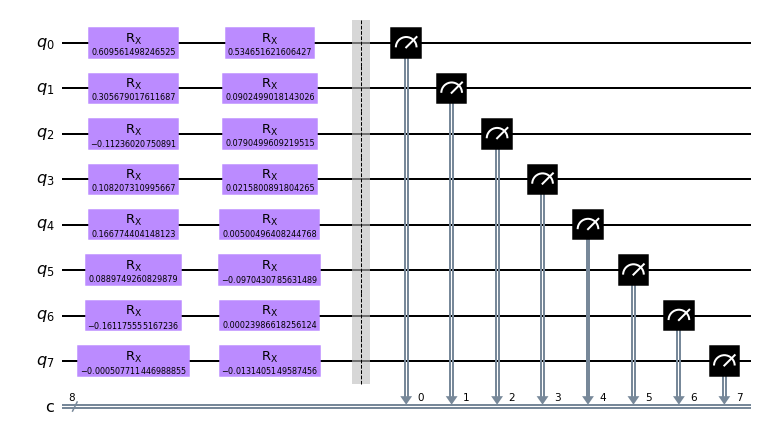

In [7]:
num_features = len(x_train[0]) # number of principal components

#Simulator and Quantum Instance parameteres
SEED = 1974
simulator = Aer.get_backend('qasm_simulator')
shots = 8092
qinst = QuantumInstance(simulator, shots, SEED)

feature_map = angle_embedding(num_features)

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qinst)

# pcas = []
# for i in range(1, len(x_train)):
#     pcas = pcas.append(x_train[0])

quantum_circuit = kernel.construct_circuit(x_train[0], x_train[1]) # This represents 2/549 of our samples in a feature map
# We will adjust for this later

print(x_train[0])
print(x_train[1])
quantum_circuit.decompose().draw('mpl')

As you can see, we have succesfully embedded the values from our training data into a kernel. Let's add an anzatz with random 

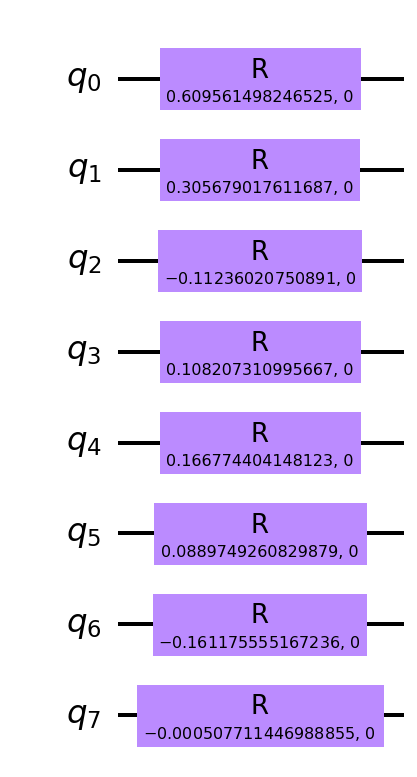

In [8]:
def image_resize(x, size):
    """
    Reshape data of (size, 1) to (size,). Useful for assigning parameters. More details found at:
    https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    """
    return np.vstack([[resize(x_i, (size, 1), anti_aliasing=False) for x_i in x]])

dimensions = len(x_train[0])

x_train_shaped = image_resize(x_train, dimensions)
x_test_shaped = image_resize(x_test, dimensions)


x_train_shaped = x_train_shaped.reshape(x_train_shaped.shape[:-1])
x_test_shaped = x_test_shaped.reshape(x_test_shaped.shape[:-1])

#Assign input parameters
feature_map.assign_parameters({k:v for (k,v) in zip(feature_map.parameters, x_train[0])}).decompose().draw('mpl', scale=2)

## Anzatz
Here we will create an anzatz to append on this circuit as a way of weighting qubits and taking advantage of Hilbert space, by encoporating y and z rotations. We will use a [two-local circuit](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html?highlight=twolocal#qiskit.circuit.library.TwoLocal), which we will assign random weights to, which will be adjusted during training.  

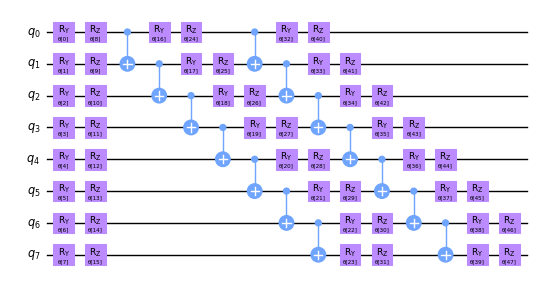

In [9]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    """
    Returns a quantum circuit 
    : feature_dim: Number of features in data
    : rotations: Types of qubit rotations
    : var_form_ep: Number of repetitions
    : ent: Type of entanglement
    """
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(dimensions, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

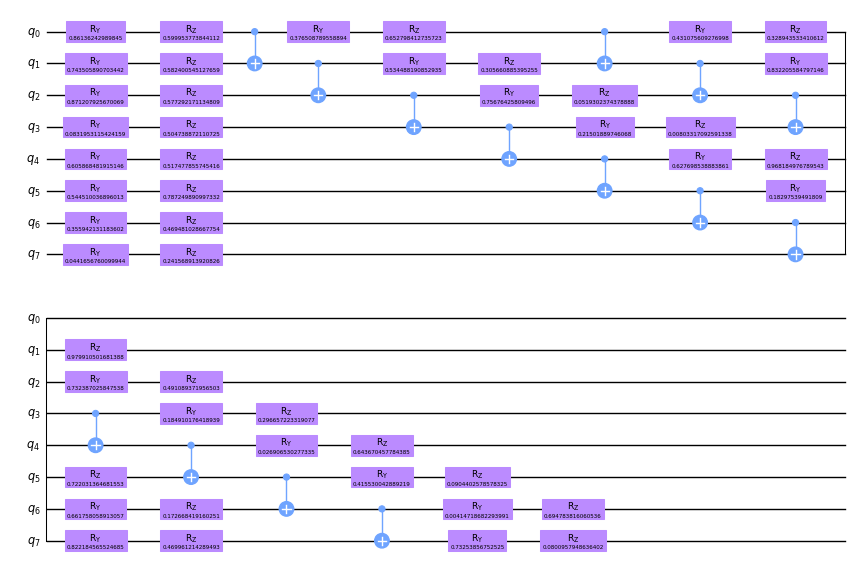

In [10]:
#We assigned weights randomly, to tweak later on
weights = np.random.random(len(ansatz_tl.parameters)) # match weights numbers to parameters
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

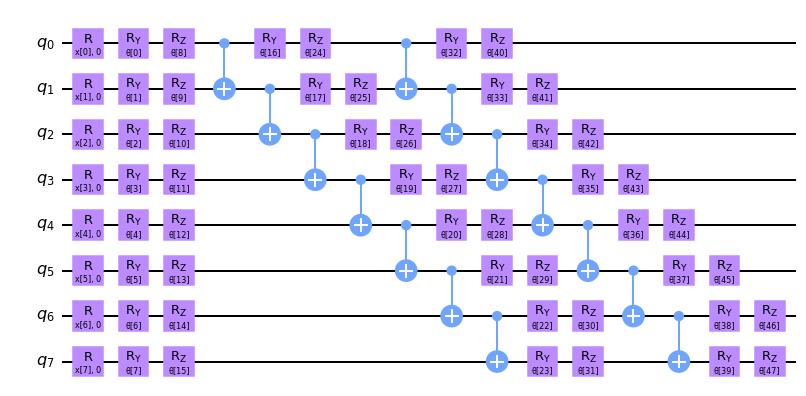

In [11]:
var_circuit = feature_map.compose(ansatz_tl) #appends circuits
var_circuit.decompose().draw('mpl') 

## CircuitQNN
As we are classifying malignant vs benign cell samples, we can classify this with a binary output, which we will need to tell our circuit quantum neural network function (CircuitQNN).

In [12]:
def one_qubit_binary(x):
    """
    Return the reainder when dividing by 2 to keep a one_qubit binary output
    """# not goof multiple classes/qubits
    return x % 2 #remainder of 2

num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=feature_map.parameters,
                 weight_params=ansatz_tl.parameters, 
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

# Forward Pass

In [13]:
forward_output = qnn.forward(x_train[0], weights)
forward_output

array([[0.54164607, 0.45835393]])

# Backward Pass

In [14]:
_, update = qnn.backward(x_train[0], weights) # _ to silence output
update

array([[[-2.95538804e-01, -5.90088977e-02, -6.40756303e-02,
          1.23578843e-04, -6.17894217e-04,  6.17894217e-05,
          4.13989125e-03, -4.81957489e-03,  5.17795353e-02,
          5.30153238e-02,  6.60528917e-02, -5.62283737e-03,
         -4.26347009e-03, -3.46020761e-03,  5.68462679e-03,
          4.13989125e-03, -3.87481463e-01,  1.51384083e-02,
          1.66831438e-03, -3.58378646e-03, -5.49925853e-03,
         -5.56104795e-04,  5.56104795e-03, -4.75778547e-03,
          9.18808700e-02,  6.65472071e-02,  4.32525952e-04,
          2.71873455e-03,  1.91547207e-03,  3.70736530e-04,
         -3.15126050e-03,  4.01631241e-03, -2.43821058e-01,
         -3.95452299e-03, -3.95452299e-03,  3.46020761e-03,
         -2.47157687e-03,  4.07810183e-03, -3.02768166e-03,
          7.22936233e-03, -1.23578843e-03,  1.66831438e-03,
         -4.94315373e-04,  1.60652496e-03,  2.71873455e-03,
          9.76272862e-03, -2.65694513e-03,  2.34799802e-03],
        [ 2.95538804e-01,  5.90088977e-

## Training with a Neural Network Classifier, OpflowQNN and Gradient Descent
Now that we have built our circuits and checked done our passes, let us begin training. One of the easiest ways to do this is with a Variation Quantum Classifier (VQC). First we'll create a function to set one hot encoding, to format data as well as a callbacl function for our optimizer. We will use an [SPSA optimizer](https://www.jhuapl.edu/SPSA/) and a [Cross Entropy Loss Function](https://rohanvarma.me/Loss-Functions/) to optimize for time and our anzatz using random weights.

In [15]:
def get_one_hot_encoding(y):
    """
    Return vectors of 0 and 1 only, from given data
    """
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train) 
y_test_1h = get_one_hot_encoding(y_test)

def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder #what does global mean? idek

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [16]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(), #label x ln()? r log10() Pr
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_shaped_norm = np.array([x/np.linalg.norm(x) for x in x_train_shaped])

vqc = vqc.fit(x_train_shaped_norm, y_train_1h) #trainnig set and labels, fit

3 - 794.9902188388035
6 - 501.867888206515
9 - 459.4711416784853
12 - 436.3702172696512
15 - 432.893587273618
18 - 427.3073226753744
21 - 427.2596689568197
24 - 394.497301212844
27 - 384.79783958021153
30 - 373.58243313738996
33 - 346.52440656278094
36 - 343.69583176051856
39 - 330.2032958496919
42 - 328.9127119813743
45 - 323.3940325819084
48 - 322.80569816839505
51 - 322.75335736768517
54 - 304.9309002480635
57 - 304.55571293476817
60 - 301.1527298735525
63 - 299.91756528881103
66 - 298.9941939268612
69 - 288.6302578899796
72 - 288.764303457751
75 - 284.7835139406683
78 - 284.7770429923015
81 - 284.3407237962722
84 - 282.46839594204647
87 - 282.46366503673914
90 - 282.04344920288946
93 - 281.6696231564331
96 - 281.7651195646667
99 - 278.684797948095
102 - 278.6695770911635
105 - 277.8290606391914
108 - 268.32398470760637
111 - 257.35884806724016
114 - 253.80092258554845
117 - 247.60272445536057
120 - 246.67885388177254
123 - 244.30756076227323
126 - 243.7099879716841
129 - 237.570122

## Final Results

In [18]:
score_train = vqc.score(x_train_shaped, y_train_1h)
score_test = vqc.score(x_test_shaped, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.9216757741347905
Score on the test set 0.95


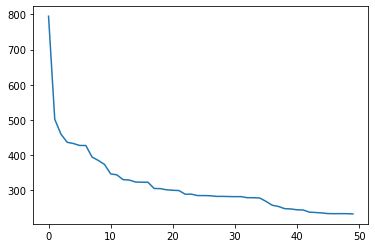

In [19]:
plt.plot(loss_recorder)